## Importing Libraries

In [21]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import nltk, re, string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from wordcloud import WordCloud

## Collection of Data

In [22]:
# query = "#russianukrainewar"
# tweets = []
# limit = 5000

# for tweet in sntwitter.TwitterSearchScraper(query).get_items():
#     if len(tweets) == limit:
#         break
#     elif tweet.lang == 'en':
#         tweets.append([tweet.date, tweet.user.username, tweet.rawContent])
        
# query = "#UkraineWar"
# limit = 10000

# for tweet in sntwitter.TwitterSearchScraper(query).get_items():
#     if len(tweets) == limit:
#         break
#     elif tweet.lang == 'en':
#         tweets.append([tweet.date, tweet.user.username, tweet.rawContent])
        
# data = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])

# data.to_csv('tweets_data.csv', index=False, header=True)

In [23]:
data = pd.read_csv('tweets_data.csv')
data.head()

,Date,User,Tweet
0,2023-04-17 13:17:34+00:00,0ok,RUSSIAN Arms Crisis as BILLIONS Lost in Arms S...
1,2023-04-17 09:18:08+00:00,Seth_Mythrax,They exist only for the State to use as it wis...
2,2023-04-17 05:04:28+00:00,_Denyshchenko,#Popasna is a city that was destroyed by russi...
3,2023-04-17 02:44:35+00:00,ogcoffeethatpay,@DudeHowler This lame Arse @WhiteHouse @SecDe...
4,2023-04-16 14:22:16+00:00,longterm_invest,@AntiWarVet86 @ghost_jenkins @RAHaarhaus @Nano...


## User Made Function for Data Cleaning and Pre-Processing

In [24]:
def cleanData(text): 
    text=text.lower()
    text=re.sub(r"i'm", "i am", text)
    text=re.sub(r"he's", "he is", text)
    text=re.sub(r"she's", "she is", text)
    text=re.sub(r"that's", "that is", text) 
    text=re.sub(r"what's", "what is", text)
    text=re.sub(r"where's", "where is", text)
    text=re.sub(r"won't", "will not", text)
    text=re.sub(r"can't", "cannot", text)
    text=re.sub(r"don't", "do not", text)
    text=re.sub(r"doesn't", "does not", text)
    text=re.sub(r"\'11", " will", text)
    text=re.sub(r"\'ve", " have", text)
    text=re.sub(r"\'re", " are", text)
    text=re.sub(r"\'d", " would", text)
    text=re.sub(r"[!-()\"#/@;:<>{}+=~|.?,\'-]", "", text)
    return text

def processData(completeData):
    data = nltk.word_tokenize(completeData)
    data = [word for word in data if word not in string.punctuation]
    data = [word for word in data if word.lower() not in stopwords.words('english')]
    return ' '.join(data)

In [25]:
data['Processed Tweet'] = data['Tweet'].apply(cleanData)
data['Processed Tweet'] = data['Processed Tweet'].apply(processData)
data['Length'] = data['Processed Tweet'].apply(len)
data.head()

,Date,User,Tweet,Processed Tweet,Length
0,2023-04-17 13:17:34+00:00,0ok,RUSSIAN Arms Crisis as BILLIONS Lost in Arms S...,russian arms crisis billions lost arms sales d...,173
1,2023-04-17 09:18:08+00:00,Seth_Mythrax,They exist only for the State to use as it wis...,exist state use wishes expendable amp mean not...,212
2,2023-04-17 05:04:28+00:00,_Denyshchenko,#Popasna is a city that was destroyed by russi...,popasna city destroyed russia result shelling ...,232
3,2023-04-17 02:44:35+00:00,ogcoffeethatpay,@DudeHowler This lame Arse @WhiteHouse @SecDe...,dudehowler lame arse whitehouse secdef amp gen...,212
4,2023-04-16 14:22:16+00:00,longterm_invest,@AntiWarVet86 @ghost_jenkins @RAHaarhaus @Nano...,antiwarvet86 ghost_jenkins rahaarhaus nanosnak...,258


## Sentiment Analysis

In [26]:
sentiment = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Processed Tweet'].apply(sentiment.polarity_scores)
data['Sentiment'] = data['Sentiment'].apply(lambda x: 'Positive' if x['compound']>=0.05
                                            else ('Negative' if x['compound']<=-0.05 else 'Neutral'))
data.head()

,Date,User,Tweet,Processed Tweet,Length,Sentiment
0,2023-04-17 13:17:34+00:00,0ok,RUSSIAN Arms Crisis as BILLIONS Lost in Arms S...,russian arms crisis billions lost arms sales d...,173,Negative
1,2023-04-17 09:18:08+00:00,Seth_Mythrax,They exist only for the State to use as it wis...,exist state use wishes expendable amp mean not...,212,Positive
2,2023-04-17 05:04:28+00:00,_Denyshchenko,#Popasna is a city that was destroyed by russi...,popasna city destroyed russia result shelling ...,232,Negative
3,2023-04-17 02:44:35+00:00,ogcoffeethatpay,@DudeHowler This lame Arse @WhiteHouse @SecDe...,dudehowler lame arse whitehouse secdef amp gen...,212,Negative
4,2023-04-16 14:22:16+00:00,longterm_invest,@AntiWarVet86 @ghost_jenkins @RAHaarhaus @Nano...,antiwarvet86 ghost_jenkins rahaarhaus nanosnak...,258,Positive


In [27]:
data['Sentiment'].value_counts()

Negative    5335
Positive    2468
Neutral     2197
Name: Sentiment, dtype: int64

## Topic Modelling

In [49]:
documents = data['Processed Tweet']
processed_docs = [simple_preprocess(doc) for doc in documents]
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

In [50]:
topics = lda_model.print_topics(num_topics=10) # specify the number of topics to extract
for topic in topics:
    print(f"Topic {topic[0]+1}: \nKeywords - {', '.join([cleanData(i.split('*')[1]) for i in topic[1].split('+')])}")

Topic 1: 
Keywords - world , peace , states , united , lets , must , amp , wars , german , president
Topic 2: 
Keywords - ukraine , way , support , like , art , available , donate , closethesky , ec , nfts
Topic 3: 
Keywords - ukrainewar , ukraine , russia , war , russian , putin , httpstco , military , us , artists
Topic 4: 
Keywords - ukraine , ukrainewar , ukrainianarmy , kherson , russia , nato , kyiv , donbass , usa , kharkiv
Topic 5: 
Keywords - geopolitics , justice , turkey , melitopol , best , source , beheading , war , ukraine , russia
Topic 6: 
Keywords - ukraine , ukrainewar , armukrainenow , stoprussia , oblast , luhansk , nft , eth , warinukraine , canada
Topic 7: 
Keywords - ukrainewar , ukraine , russianarmy , wwiii , ukrainianarmy , russian , ukrainian , httpstco , region , himars
Topic 8: 
Keywords - ukrainewar , war , ukraine , russia , us , amp , nato , putin , documents , china
Topic 9: 
Keywords - ukraine , ukrainewar , ukrainian , russia , russian , war , httpstc

In [51]:
doc_topic_dist = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topic_dist = sorted(doc_topic_dist, key=lambda x: x[0][1], reverse=True) # sort the topics by proportion
for topic in doc_topic_dist[:10]:
    print(f"Topic {topic[0][0]+1}: Proportion - {topic[0][1]}")

Topic 3: Proportion - 0.972619354724884
Topic 8: Proportion - 0.967818558216095
Topic 8: Proportion - 0.9666095972061157
Topic 8: Proportion - 0.9666094779968262
Topic 8: Proportion - 0.9666094183921814
Topic 3: Proportion - 0.966583788394928
Topic 3: Proportion - 0.9665764570236206
Topic 10: Proportion - 0.966564416885376
Topic 8: Proportion - 0.9665176868438721
Topic 3: Proportion - 0.966503918170929


In [52]:
doc_topic_dist = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topic_dist = sorted(doc_topic_dist, key=lambda x: x[0][0], reverse=True) # sort the topics by topic
for topic in doc_topic_dist[:10]:
    print(f"Topic {topic[0][0]+1}: Proportion - {topic[0][1]}")

Topic 10: Proportion - 0.9356713891029358
Topic 10: Proportion - 0.9639592170715332
Topic 10: Proportion - 0.9639590382575989
Topic 10: Proportion - 0.9608469605445862
Topic 10: Proportion - 0.9639379382133484
Topic 10: Proportion - 0.9608469605445862
Topic 10: Proportion - 0.9608469605445862
Topic 10: Proportion - 0.9590693116188049
Topic 10: Proportion - 0.9638534188270569
Topic 10: Proportion - 0.9499384760856628


In [53]:
doc_topic_dist = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topic_df = pd.DataFrame(doc_topic_dist, columns=[f"Topic {i+1}" for i in range(lda_model.num_topics)])
doc_topic_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,"(2, 0.44129816)","(3, 0.2340604)","(7, 0.29256317)",None,None,None,None,None,None,None
1,"(3, 0.21103492)","(6, 0.32630804)","(7, 0.33012703)","(9, 0.09917107)",None,None,None,None,None,None
2,"(5, 0.6589536)","(6, 0.30102095)",None,None,None,None,None,None,None,None
3,"(0, 0.040728386)","(1, 0.039312683)","(3, 0.05746852)","(5, 0.31130815)","(7, 0.25860086)","(8, 0.2782168)",None,None,None,None
4,"(0, 0.07691053)","(2, 0.82721215)","(5, 0.07314558)",None,None,None,None,None,None,None


In [54]:
for i in doc_topic_df.columns.values:
    doc_topic_df[i] = doc_topic_df[i].apply(lambda x: 0 if x is None else x[1])
doc_topic_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.441298,0.234060,0.292563,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.211035,0.326308,0.330127,0.099171,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.658954,0.301021,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.040728,0.039313,0.057469,0.311308,0.258601,0.278217,0.0,0.0,0.0,0.0
4,0.076911,0.827212,0.073146,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


## Data Visualisation

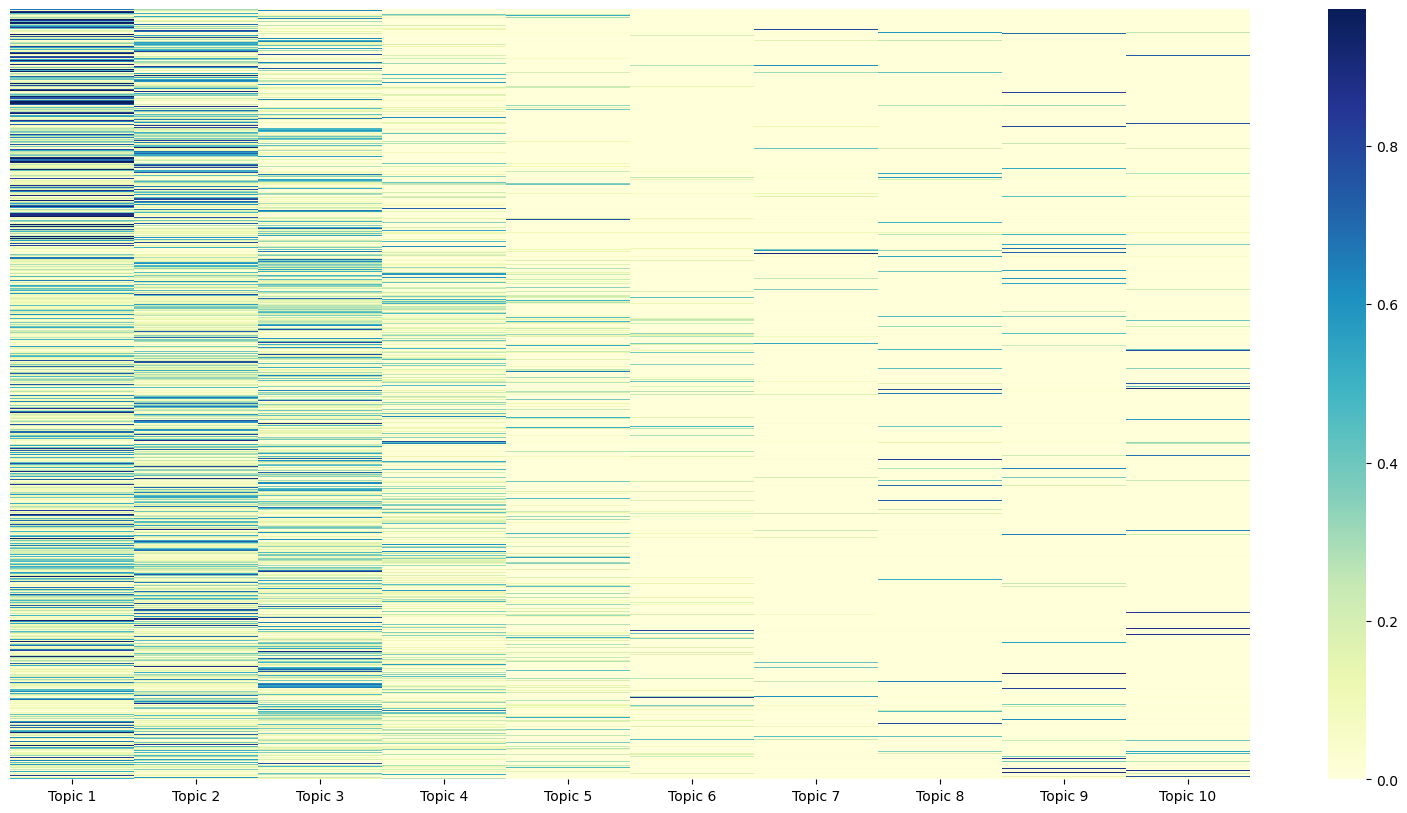

In [55]:
plt.figure(figsize=(20, 10))
sns.heatmap(doc_topic_df, cmap="YlGnBu", cbar=True)
plt.yticks([]) 
plt.show()

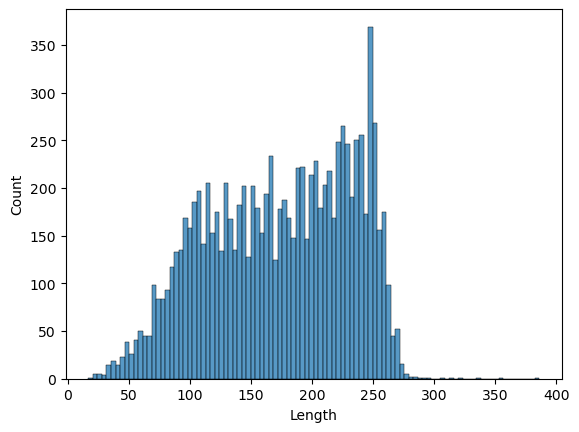

In [48]:
sns.histplot(x='Length', data=data, bins=100)
plt.show()

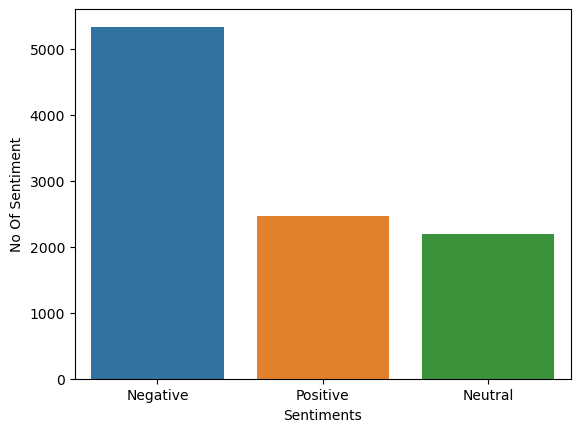

In [81]:
sns.countplot(x='Sentiment', data=data)
plt.xlabel("Sentiments")
plt.ylabel("No Of Sentiment")
plt.show()

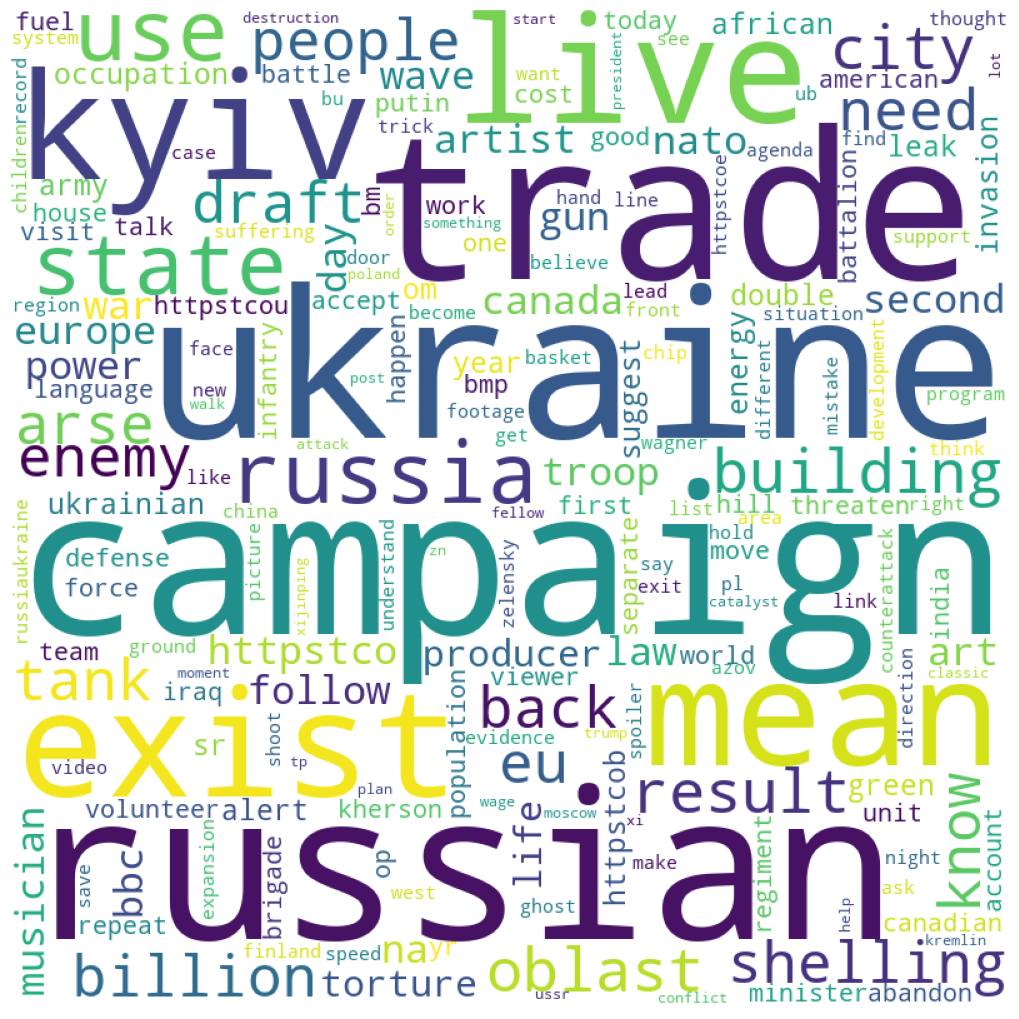

In [69]:
wordlist = [word for word in dictionary.itervalues()]
wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(' '.join(wordlist))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

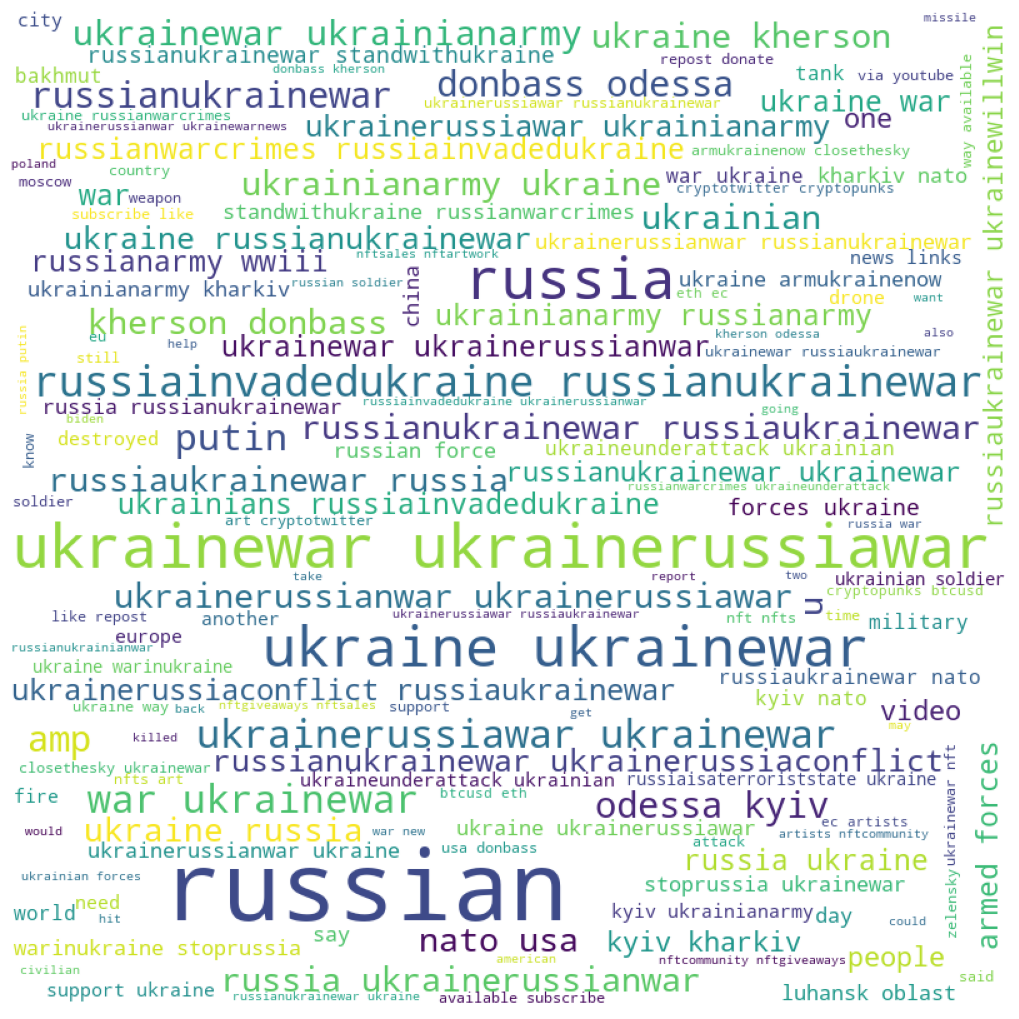

In [85]:
wordlist = [word for sentence in data['Processed Tweet'] for word in sentence.split()]
wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                      stopwords = stopwords.words('english'),
                      min_font_size = 10).generate(' '.join(wordlist))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()